# Setup

## Import packages

In [1]:
############################################################################################################################ 
# Get the latest CREST files for each ID within the target folder (dirname)

from pathlib import Path
import json
from sqlite3 import connect as sqlite3_connect
from sqlite3 import DatabaseError
from igraph import Graph as ig_Graph
from igraph import plot as ig_plot
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from scipy.stats import zscore
from random import choice as random_choice
from itertools import combinations
from numpy import array, unravel_index, argmin, mean
import random
import numpy as np
from copy import deepcopy
import itertools
from datetime import datetime
from time import time
import neuroglancer
from webbrowser import open as wb_open
from webbrowser import open_new as wb_open_new
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import networkx as nx
from tqdm import tqdm

In [2]:
import sys
sys.path.append('/Users/kperks/Documents/ell-connectome/eCREST/eCREST')

In [3]:
# from eCREST_cli_beta import ecrest, import_settings
from eCREST_cli import ecrest, import_settings, get_cell_filepaths

In [4]:
def sns_joint_equal_axes(g):
    
    g.ax_joint.set_aspect('equal')
    
    # Get the position of the joint plot and marginal plots
    joint_position = g.ax_joint.get_position()
    xmarg_position = g.ax_marg_x.get_position()
    ymarg_position = g.ax_marg_y.get_position()

    # Set the position and size of the x-axis marginal plot
    g.ax_marg_x.set_position([xmarg_position.x0, joint_position.y1 + 0.02, joint_position.width, xmarg_position.height])

    # Set the position and size of the y-axis marginal plot
    g.ax_marg_y.set_position([ymarg_position.x0, joint_position.y0, ymarg_position.width, joint_position.height])
    
    return g


def pairwise_distances(df, target_ids, dimensions = ['soma_x', 'soma_y_adj', 'soma_z'], source_ids = None, source_coords = None):
    # Extract source coordinates
    if source_ids is not None:
        # source_ids is a tuple of ('column_name',[column_values])
        source_coords = df[df[source_ids[0]].isin(source_ids[1])].loc[:, dimensions].values
    
    # Extract target coordinates
    # target_ids is a tuple of ('column_name',[column_values])
    target_coords = df[df[target_ids[0]].isin(target_ids[1])].loc[:, dimensions].values

    # Handle NaN values
    source_coords = np.nan_to_num(source_coords, nan=np.nan)
    target_coords = np.nan_to_num(target_coords, nan=np.nan)

    # Calculate pairwise distances
    distances = np.linalg.norm(source_coords - target_coords, axis=-1)
    
    return distances

## Import settings

If you save a copy of settings_dict.json (found in the "under construction" directory of eCREST repo) locally somewhere outside the repo (like in your save_dir), then you can use the following code cell to import. This avoids needing to re-type the save_dir and db_path each time you "git pull" updates from the repo to this notebook.

In [5]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

vx_sizes = [16,16,30]

# Molecular layer fit

In [6]:
from scipy.optimize import curve_fit 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D 

In [7]:
# Define mathematical function for curve fitting 
def func(xy, a, b, c, d, e, f, g, h):  # #h):#
    x, y = xy 
    return a + b*x + c*y + d*x**2 + e*y**2 + f*x**3 + g*y**3 + h*x*y # + h*x*y #

In [8]:
Path(settings_dict['save_dir']).parent.parent

PosixPath('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome')

In [9]:
neuroglancer_path = Path(settings_dict['save_dir']).parent.parent / 'blender/soma_locations/layer-molecular_annotation.json'
voxel_sizes = [16,16,30]
nl_ = 'molecular'

with open(Path(neuroglancer_path), 'r') as myfile: # 'p' is the dirpath and 'f' is the filename from the created 'd' dictionary
    neuroglancer_data = json.load(myfile)
    
neuroglancer_layer = next((item for item in neuroglancer_data['layers'] if item["name"] == nl_), None)
vertices = [[p['point'][i]*voxel_sizes[i] for i in range(3)] for p in neuroglancer_layer['annotations']]

x_pts = [p[0] for p in vertices]
y_pts = [p[1] for p in vertices]
z_pts = [p[2] for p in vertices]

In [10]:
# Perform curve fitting 
popt, pcov = curve_fit(func, (x_pts, z_pts), y_pts) 
  
# Print optimized parameters 
print(popt) 

[ 2.71956920e+05 -5.43115077e-02 -1.87026179e-01 -3.46153667e-07
  2.31048373e-06  9.59242290e-13 -1.51595014e-11  6.68290149e-07]


# Load files

## mg_network file names

In [11]:
dirpath = Path(settings_dict['save_dir'])


In [12]:
nodefiles = get_cell_filepaths(dirpath)

In [13]:
len(nodefiles)

5710

## df_syn pre or post

In [22]:
df_syn = pd.read_csv(dirpath / 'graphs/df_presyn.csv')
syn = 'pre-synaptic'

In [23]:
len(df_syn)

10564

In [24]:
df_syn = df_syn.rename(columns={'pre':'post','post':'pre','pre_type':'post_type','post_type':'pre_type'})
df_syn

,Unnamed: 0,post,pre,structure,x,y,z
0,0,126649726,305329558,axon,333376,306304,50700
1,1,126649726,221714230,axon,341472,295248,37110
2,2,126649726,302730452,axon,229456,307280,52860
3,3,126649726,44244249,axon,337200,270496,19050
4,4,126649726,559551706,axon,322752,307680,65130
...,...,...,...,...,...,...,...
10559,10559,647514445,648708832,axon,284341,311143,92354
10560,10560,647514445,558189299,axon,283112,311022,92295
10561,10561,647514445,563945132,axon,281567,311318,92655
10562,10562,647514445,563945132,axon,277548,307095,94694


In [18]:
y_adj_col = []
for i,r in df_syn.iterrows():
    yoffset = func((r['x'], r['z']), *popt)
    y_adj = (r['y'] - yoffset)
    y_adj_col.append(y_adj)

df_syn.loc[:,'y_adj']=y_adj_col

for v in ['x','y','z','y_adj']:
    df_syn[v] = df_syn[v]/1000
df_syn['y_adj'] = df_syn['y_adj']*-1    

# cell types for all files in directory

## from file

In [25]:
df_type = pd.read_csv(dirpath / 'metadata/df_type.csv')

## manual type

In [15]:
cell_type = {}
not_typed = []
for x,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    cell_type[int(x)] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        cell_type[int(x)]=np.NaN
        not_typed.append(x)# print(f'cell {x} is not cell-typed in json')
        
print('the following cells are not typed in the main network')
print(not_typed)        
        
df_type = pd.DataFrame(cell_type.items(),columns = ['id','cell_type'])

df_type.loc[df_type['cell_type'].isin(['dml']),'cell_type']='mli'
df_type.loc[df_type['cell_type'].isin(['grc-d']),'cell_type']='grc'
df_type.loc[df_type['cell_type'].isin(['grc-s']),'cell_type']='smpl'
df_type.loc[df_type['cell_type'].isin(['pfm']),'cell_type']='pf'

the following cells are not typed in the main network
[]


## auto type

this field is populated when an auto-typing of the cells was different from the manual typing

In [16]:
cell_type = {}
# not_typed = []
for x,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    cell_type[int(x)] = cell.get_ctype('auto') 
    if (cell.get_ctype('auto') == []) | (cell.get_ctype('auto') == ''):
        cell_type[int(x)]=np.NaN
        # not_typed.append(x)# print(f'cell {x} is not cell-typed in json')
        
# print('the following cells are not typed in the main network')
# print(not_typed)        
        
df_type_auto = pd.DataFrame(cell_type.items(),columns = ['id','cell_type'])


In [17]:
df_type_auto.dropna(inplace=True)

In [18]:
df_type_auto.head()

,id,cell_type
98,127607174,mg2
100,127672247,mg2
148,129572524,mg1
724,213501262,mg1
749,214440956,mg2


## combine manual and auto df_type

In [19]:
for i,r in df_type_auto.iterrows():
    df_type.loc[i,'cell_type'] = r['cell_type'] # the match up of i for df_type and _auto depends on both being made by iterating over the same nodefiles list

In [20]:
df_type.head()

,id,cell_type
0,102463116,pf
1,103366246,uk
2,103549879,mli
3,109461049,fov
4,109502641,mli


In [154]:
df_type[df_type['cell_type'].isin(['sg1','sg2'])]

,Unnamed: 0,id,cell_type
100,100,127641472,sg1
104,104,127700739,sg2
109,109,127838393,sg1
111,111,127857293,sg1
121,121,128614407,sg1
...,...,...,...
5276,5276,649497765,sg2
5283,5283,649572893,sg2
5295,5295,649805291,sg2
5312,5312,650501012,sg2


# add cell type to df_syn

In [26]:
for i,r in df_syn.iterrows():
    try:
        df_syn.loc[i,'pre_type'] =df_type[df_type['id'].isin([r['pre']])].cell_type.values[0]
        df_syn.loc[i,'post_type']=df_type[df_type['id'].isin([r['post']])].cell_type.values[0]
    except:
        print(r['pre'],r['post'])
        continue

# df_syn.loc[:,'post_type'] = [t.lower() for t in df_syn['post_type']]
# df_syn.loc[:,'pre_type'] = [t.lower() for t in df_syn['pre_type']]

In [18]:
df_syn.head()

,Unnamed: 0,post,pre,structure,x,y,z,y_adj,pre_type,post_type
0,0,126649726,305329558,axon,333.376,306.304,50.70,-49.606710,sg1,mg2
1,1,126649726,221714230,axon,341.472,295.248,37.11,-40.070481,smpl,mg2
2,2,126649726,302730452,axon,229.456,307.280,52.86,-51.985349,sg1,mg2
3,3,126649726,44244249,axon,337.200,270.496,19.05,-17.969978,smpl,mg2
4,4,126649726,559551706,axon,322.752,307.680,65.13,-49.580579,mg1,mg2


# filter df_syn

## include only classic mg2 for main analysis

In [27]:
mg2_post_classic = [[386426114, 214581797, 213605530, 126649726, 299404889]]
mg2_post_spectrum = [385434515,386392158,221746236,215492896,387850816,216129202,300226567]
df_syn = df_syn[~df_syn['post'].isin(mg2_post_spectrum)]

## subselect post_syn types to include

In [28]:
df_syn = df_syn[df_syn['post_type'].isin(['mg1','mg2','lg','lf','sg1','sg2','grc','smpl'])]

In [29]:
df_syn['post_type'].unique()

array(['mg2', 'sg1', 'sg2', 'smpl', 'grc', 'mg1', 'lg', 'lf'],
      dtype=object)

## save filtered df_syn

In [34]:
savepath = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/CREST_reconstructions/mg-network/graphs')

df_syn = df_syn.drop(['pre_type','post_type'],axis=1)
df_syn.to_csv(savepath / 'df_presyn_filt.csv')

In [194]:
# # include only connections to the following types/groups of cells
# pre_groups = ['mg1','mg2']
# post_groups = ['mg1','mg2','lg','lf']
# df_syn = df_syn[(df_syn['post_type'].isin(post_groups)) & df_syn['pre_type'].isin(pre_groups)]
# len(df_syn)

6196

# shuffle df_syn

In [48]:
df_syn_rand = deepcopy(df_syn)

shuff_rows = df_syn_rand[['pre','pre_type']].sample(frac = 1)
df_syn_rand.loc[:,['pre']] = shuff_rows['pre'].values
df_syn_rand.loc[:,['pre_type']] = shuff_rows['pre_type'].values

df_syn = df_syn_rand

# --> df_edges

In [198]:
df_syn.head()

,Unnamed: 0,pre,post,structure,x,y,z,y_adj,pre_type,post_type
0,0,126618353,303212610,basal dendrite,369.840,314.688,52.26,-54.350501,mg1,mg2
1,1,126618353,387850816,basal dendrite,369.584,313.776,52.26,-53.468711,mg1,mg2
2,2,126618353,303212610,basal dendrite,368.736,314.784,52.56,-54.523112,mg1,mg2
3,3,126618353,394686712,unknown,370.112,314.832,52.62,-54.398373,mg1,lf
5,5,126618353,394686712,basal dendrite,359.792,314.608,51.39,-55.535101,mg1,lf


In [162]:
# remove structure and soma diameter information if want to
# df_syn = df_syn.drop(['Unnamed: 0','x','y','z','structure'],axis=1)#,'pre_diam','post_diam','diam_diff'],axis=1) # 

In [23]:
df_edges=df_syn[['pre','post','pre_type','post_type']].value_counts().reset_index(name='weight')

## probe df_syn and df_edges

### synapse locations to csv for model

In [44]:
mask = df_syn['post'].isin([393433572]) #& df_edges['pre_type'].isin(['aff'])
df_syn[mask].drop(columns=['Unnamed: 0', 'structure']).to_csv('/Users/kperks/Downloads/syn_SG2_393433572_nm.csv')

### filter df_edges for counts, etc

In [42]:
mask = df_edges['post'].isin([299496636,214581797,393325331,301787806])  & df_edges['pre_type'].isin(['aff','smpl','grc','sg1','sg2'])
df_edges[mask].groupby(['post','post_type','pre_type'])['pre'].count()#number of presynaptic cells by type
# df_edges[mask].groupby(['post','post_type','pre_type'])['weight'].sum(numeric_only=True)#number of presynaptic synapses by type

post       post_type  pre_type
214581797  mg2        aff           3
                      grc           1
                      sg1          86
                      smpl         13
299496636  mg1        grc          87
                      sg2          57
301787806  lg         grc         123
                      sg2          30
                      smpl          1
393325331  lf         aff           9
                      grc           1
                      sg1          53
                      smpl         20
Name: pre, dtype: int64

In [23]:
mask = df_edges['post_type'].isin(['grc']) & df_edges['pre_type'].isin(['aff'])
df_edges[mask].groupby(['post','pre']).sum()

pre_type post_type  weight
post      pre                                 
222597526 55424451       aff       grc       2
          56553977       aff       grc      12
          56569586       aff       grc       3
          668081112      aff       grc       5
223881844 60081840       aff       grc      19
          60129918       aff       grc       1
          60192229       aff       grc       5
226019332 54372224       aff       grc       5
          55472256       aff       grc       3
          55487871       aff       grc       1
          56553977       aff       grc      14
          56569586       aff       grc       9
          56662421       aff       grc       1
          57714981       aff       grc       1
227254070 61319896       aff       grc       1
          668081112      aff       grc       4
          669119245      aff       grc       6
228321391 56569586       aff       grc       1
228366816 54372224       aff       grc       1
          55472256       aff       grc       2
          55487871       aff       grc       1
          56569586       aff       grc       3
          56662421       aff       grc       1
          57714981       aff       grc       2
313068329 668081112      aff       grc       4
          669119245      aff       grc       2
395461156 317600983      aff       grc       6
          396591516      aff       grc       1
          663392333      aff       grc       7
          668081112      aff       grc       4
          670337293      aff       grc       1
400210172 60097298       aff       grc       1
          60159066       aff       grc       2
403522169 668081112      aff       grc       3
481412554 60143700       aff       grc       7
          61319896       aff       grc       1
          666982330      aff       grc       1
          668081112      aff       grc      27
          669119245      aff       grc       7
482680782 58967760       aff       grc       3
          60081840       aff       grc      15
          60129918       aff       grc       1
          60159066       aff       grc      14
          60192229       aff       grc      23
          668081112      aff       grc       1
          668343333      aff       grc       1
          669119245      aff       grc       3
483610898 317600983      aff       grc       9
          396591516      aff       grc       3
483689146 60143700       aff       grc      10
          61319896       aff       grc       4
          668081112      aff       grc      22

In [31]:
mask = df_edges['post_type'].isin(['sg2'])
df_edges[mask].groupby(['post','pre_type']).sum(numeric_only=True).head(100)#.reset_index()

pre  weight
post      pre_type                    
50786130  aff       1561037314      35
          fov       2335372842      14
          h          622527144       2
          sg1       2639441316      20
          sgx1       822148256       4
...                        ...     ...
647514445 aff       2065502583      19
          fov       5023100995      20
          sg1       5864809200      36
          sgx1      1686020191      10
          smpl       306338104       2

[87 rows x 2 columns]

In [23]:
df_edges[mask]['post'].unique()

array([389891998,  50786130, 393433572, 306461085, 647514445, 218095913,
       387415866, 394423863, 477962738, 395507584, 473491444])

In [30]:
mask = df_edges['post'].isin([226019332]) & df_edges['pre_type'].isin(['aff'])
df_edges[mask]['pre'].values

array([56553977, 56569586, 54372224, 55472256, 55487871, 56662421,
       57714981])

# Color Palette

In [43]:
syn_colors = {
    'sgx1':'#B2D732', #'#996633',
    'sgx2':'#FCCC1A',
    'sg1':'#B2D732',
    'sg2':'#FCCC1A',
    'grc':'#FEFE33',
    'smpl':'#8601AF',
    'dml':'#cccccc',
    'mg1':'#00CBFF',#'#347C98',#'#357D99',#'#80DBFF',##'#0000ff',
    'mg2':'#FB9902',#'#ff0000',
    'lf':'#FE2712',#'#8000c8',
    'lg':'#0247FE',#'#c80080',
    'aff':'#ffc0cb',
    'tsd':'#737373',
    'pe':'#550055',
    'pf':'#880088',
    'mli':"000000",
    # 'uk':,
    # 'fov':,
    'h':'#666666'
}

# synapses locations in df_syn

## absolute

In [44]:
df_syn['depth'] = pd.cut(df_syn['y_adj'], bins=np.arange(-100,20,5))

In [45]:
df_syn.head()

,Unnamed: 0,post,pre,structure,x,y,z,y_adj,pre_type,post_type,depth
0,0,126649726,305329558,axon,333.376,306.304,50.70,-49.606710,sg1,mg2,"(-50, -45]"
1,1,126649726,221714230,axon,341.472,295.248,37.11,-40.070481,smpl,mg2,"(-45, -40]"
2,2,126649726,302730452,axon,229.456,307.280,52.86,-51.985349,sg1,mg2,"(-55, -50]"
3,3,126649726,44244249,axon,337.200,270.496,19.05,-17.969978,smpl,mg2,"(-20, -15]"
4,4,126649726,559551706,axon,322.752,307.680,65.13,-49.580579,mg1,mg2,"(-50, -45]"


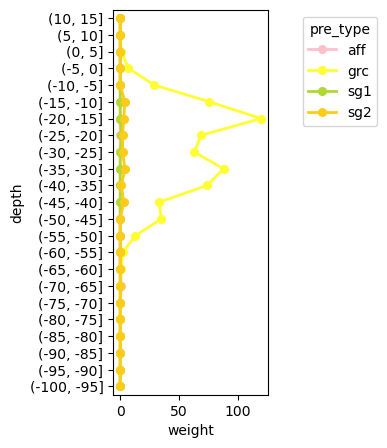

In [60]:
# mask = df_syn['post_type'].isin(['mg1']) & df_syn['pre_type'].isin(['grc','sg2','mg2'])
post_target = 'sg1'
mask = df_syn['post_type'].isin([post_target]) & df_syn['pre_type'].isin(['aff','smpl','sg1','grc','sg2'])

df_grouped = df_syn[mask][['post','pre_type','depth']].groupby(['depth','pre_type'],observed=False).count().reset_index()
df_grouped.rename(columns={'post':'weight'},inplace=True)

df_grouped.loc[df_grouped['pre_type'].isin(['sg1','sg2']),'class'] = 'sg'
df_grouped.loc[df_grouped['pre_type'].isin(['mg1','mg2']),'class'] = 'mg'
df_grouped.loc[df_grouped['pre_type'].isin(['lf','lg']),'class'] = 'output'
df_grouped.loc[df_grouped['pre_type'].isin(['mli','tsd','dml','h']),'class'] = 'smooth'
df_grouped.loc[df_grouped['pre_type'].isin(['grc','smpl']),'class'] = 'small'
df_grouped.loc[df_grouped['pre_type'].isin(['aff']),'class'] = 'afferent'

df_grouped['weight_norm'] = df_grouped.groupby('depth',observed=False)['weight'].transform(lambda x: (x / x.sum()) )

df_grouped['weight_all'] = df_grouped.groupby('depth',observed=False)['weight'].transform(lambda x: (x.sum()) )


# Create a seaborn plot
hfig,ax = plt.subplots(1,figsize=(2,5))
sns.pointplot(data=df_grouped,y='depth', x='weight',hue = 'pre_type',palette=syn_colors,linewidth=2)#,order = ['lg','mg1','sg1','lf','mg2','sg2'])
ax.invert_yaxis()
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.75, 1));
# plt.savefig('/Users/kperks/Downloads/mg1_pre_synapse_locations_binned.svg',transparent=True) 
plt.savefig(f'/Users/kperks/Downloads/{post_target}_pre_synapse_locations_binned.png',transparent=True) 

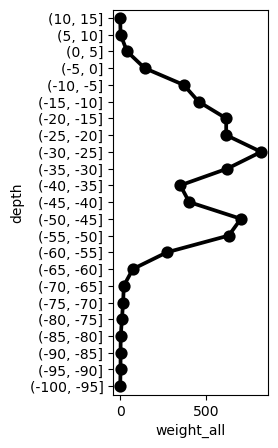

In [230]:
hfig,ax = plt.subplots(1,figsize=(2,5))
sns.pointplot(data=df_grouped,y='depth', x='weight_all',color='black')
ax.invert_yaxis()

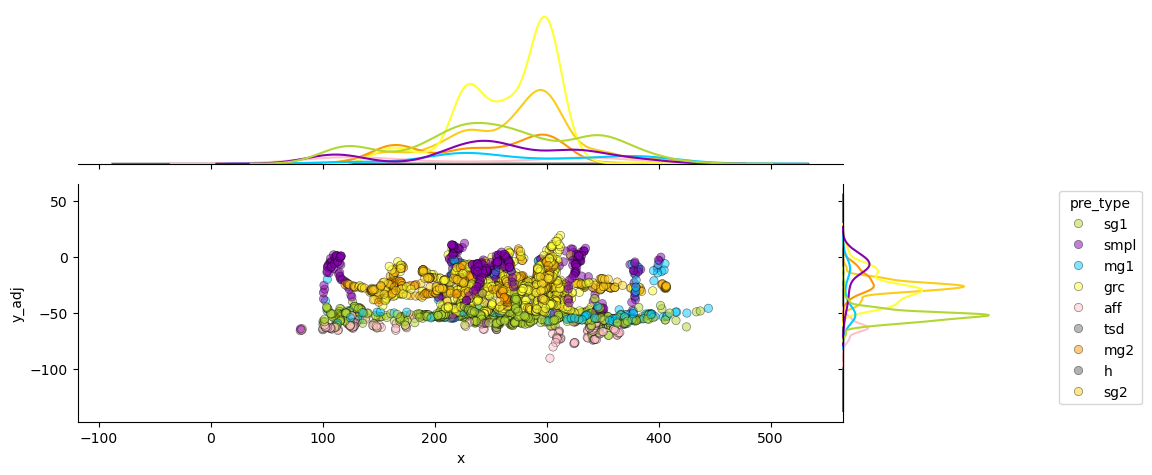

In [22]:
mask = df_syn['post_type'].isin(['mg2','mg1','lg']) & df_syn['pre_type'].isin(['aff','grc','smpl','sg1','sg2','mg1','mg2','tsd','h'])
g = sns.jointplot(data=df_syn[mask], #['aff','sg2','mg2','sg1','mg1','grc-d','grc-s']
                  x="x", y="y_adj", hue="pre_type", height=10,
                  alpha = 0.5, edgecolor='black',palette = syn_colors,
                 marginal_kws=dict(common_norm=True,clip_on=0, fill=False), space=0)
# sns.scatterplot(x=[0],y=[0],color='black',s=100);

sns_joint_equal_axes(g);
sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

# g = sns.jointplot(data=df_syn[df_syn['pre_type'].isin(['mg2','mg1'])], #['aff','sg2','mg2','sg1','mg1','grc-d','grc-s']
#                   x="x", y="z", hue="pre_type", height=10,
#                   alpha = 0.5, edgecolor='black',palette = syn_colors,
#                  marginal_kws=dict(common_norm=True,clip_on=0, fill=False), space=0)
# # sns.scatterplot(x=[0],y=[0],color='black',s=100);

# sns_joint_equal_axes(g);
# sns.move_legend(plt.gca(), "upper right", bbox_to_anchor=(1.4, 1));

## soma synapses

In [38]:
df_syn.head()
mask = df_syn['post_type'].isin(['mg1','mg2','lg']) & df_syn['pre_type'].isin(['aff','grc','smpl','sg1','sg2'])
df_syn[mask].head()

,Unnamed: 0,post,pre,structure,x,y,z,y_adj,pre_type,post_type
0,0,126649726,305329558,axon,333.376,306.304,50.70,-49.606710,sg1,mg2
1,1,126649726,221714230,axon,341.472,295.248,37.11,-40.070481,smpl,mg2
2,2,126649726,302730452,axon,229.456,307.280,52.86,-51.985349,sg1,mg2
3,3,126649726,44244249,axon,337.200,270.496,19.05,-17.969978,smpl,mg2
6,6,126649726,47692492,axon,323.216,259.600,19.02,-7.687260,smpl,mg2


<AxesSubplot:xlabel='x', ylabel='y_adj'>

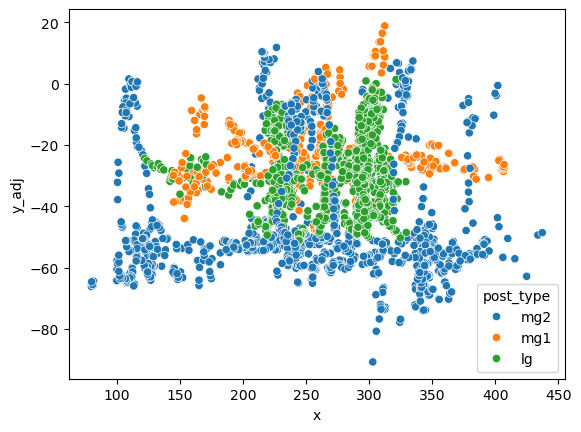

In [39]:
sns.scatterplot(data=df_syn[mask],x='x',y='y_adj',hue = 'post_type')

In [37]:
df_syn[mask].groupby(['post_type','post','pre_type']).count()

Unnamed: 0  pre  structure   x   y   z  y_adj
post_type post      pre_type                                               
lg        300474334 grc                6    6          6   6   6   6      6
          301787806 grc                1    1          1   1   1   1      1
          472392041 grc                4    4          4   4   4   4      4
                    sg1                1    1          1   1   1   1      1
mg1       299392199 grc                7    7          7   7   7   7      7
          299405462 grc                4    4          4   4   4   4      4
mg2       213605530 aff                1    1          1   1   1   1      1
          214581797 aff                3    3          3   3   3   3      3
          215492896 aff               24   24         24  24  24  24     24
          221746236 aff               38   38         38  38  38  38     38
          299404889 aff                4    4          4   4   4   4      4
          300226567 aff               33   33         33  33  33  33     33
          385434515 aff                5    5          5   5   5   5      5
          386392158 aff                7    7          7   7   7   7      7
          386426114 aff                2    2          2   2   2   2      2

# Connectivity Similarity

## correlation

In [41]:
# Desired source and order
source_types_order = ['lg','mg1','lf','mg2']#['lg','mg1','sg1','smpl','lf','mg2','sg2','grc']

# Desired targets order
target_types_order = ['aff','grc', 'smpl','sg2', 'sg1', 'mg2', 'mg1']  #['aff', 'smpl','sgx1','sg1', 'grc', 'sgx2', 'sg2']#

In [42]:
# dsource = 'post_type'
# idsource = 'post'
# dtarget = 'pre_type'

# post-synaptic labeling
dsource = 'post_type'
idsource = 'post'
dtarget = 'pre_type'

# Filter out rows with post_type not in post_types_order
df_edges_filtered = df_edges[df_edges[dsource].isin(source_types_order)]

# Pivot table to get sum of weights per post and pre_type
pivot_df = df_edges_filtered.pivot_table(values='weight', index=[idsource, dsource], columns=dtarget, aggfunc='sum', fill_value=0)

# Reindex columns to include only the specified pre_types in the desired order
pivot_df = pivot_df.reindex(columns=target_types_order, fill_value=0)

# Reset index to turn 'post' and 'post_type' from index to columns
pivot_df.reset_index(inplace=True)

# Sort the dataframe based on post_type
pivot_df[dsource] = pd.Categorical(pivot_df[dsource], categories=source_types_order, ordered=True)
pivot_df.sort_values(dsource, inplace=True)
pivot_df.set_index(idsource, inplace=True)

In [43]:
pivot_df.head()

pre_type,post_type,aff,grc,smpl,sg2,sg1,mg2,mg1
post,,,,,,,,
301787806,lg,0,199,1,157,0,45,0
300474334,lg,0,176,0,61,0,42,0
301727988,lg,0,78,0,55,0,20,0
472392041,lg,0,195,4,58,1,44,0
302637877,lg,0,7,0,29,0,47,0


In [44]:
pivot_df[pivot_df['post_type'].isin(['mg2'])].index

Int64Index([386426114, 299404889, 214581797, 213605530, 126649726], dtype='int64', name='post')

## cosine similarity

In [45]:
def cosine_similarity(A, B):
    # The time-series data sets should be normalized.
    A_norm = (A - np.mean(A)) / np.std(A)
    B_norm = (B - np.mean(B)) / np.std(B)
 
    # Determining the dot product of the normalized time series data sets.
    dot_product = np.dot(A_norm, B_norm)
 
    # Determining the Euclidean norm for each normalized time-series data collection.
    norm_A = np.linalg.norm(A_norm)
    norm_B = np.linalg.norm(B_norm)
 
    # Calculate the cosine similarity of the normalized time series data 
    # using the dot product and Euclidean norms. setse-series data set
    cosine_sim = dot_product / (norm_A * norm_B)
 
    return cosine_sim
    
# from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from numpy.linalg import norm


In [46]:
pivot_df.head()

pre_type,post_type,aff,grc,smpl,sg2,sg1,mg2,mg1
post,,,,,,,,
301787806,lg,0,199,1,157,0,45,0
300474334,lg,0,176,0,61,0,42,0
301727988,lg,0,78,0,55,0,20,0
472392041,lg,0,195,4,58,1,44,0
302637877,lg,0,7,0,29,0,47,0


In [47]:
# Normalize each row to unit length (L2 norm)
pivot_df_corr = pivot_df.drop(columns=[dsource])
# pivot_df_corr=pivot_df_corr.apply(zscore, axis=1) # DO NOT Z-SCORE: it will then just be correlation coefficient 
# (https://stats.stackexchange.com/questions/235673/is-there-any-relationship-among-cosine-similarity-pearson-correlation-and-z-sc)
normalized_df = pivot_df_corr.div(norm(pivot_df_corr, axis=1), axis=0)
normalized_df.dropna(inplace=True)#.replace(np.NaN,0)

In [48]:
cosine_sim_matrix = pairwise_distances(normalized_df, metric='cosine')
cosine_sim_matrix = 1-cosine_sim_matrix
cosine_sim_df = pd.DataFrame(cosine_sim_matrix, index=normalized_df.index, columns=normalized_df.index)

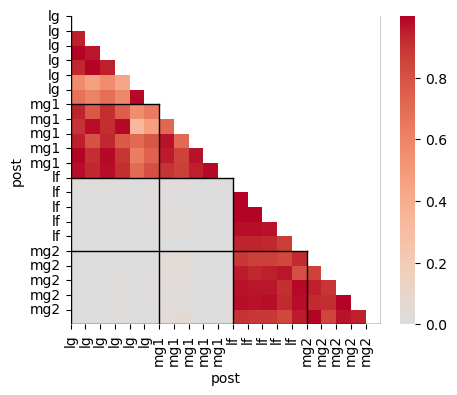

In [51]:
# Create the heatmap
plt.figure(figsize=(5, 4))

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(cosine_sim_df, dtype=bool))

heatmap = sns.heatmap(cosine_sim_df, mask=mask,cmap='coolwarm', annot=False, fmt='.2f', cbar=True,center=0) #

# Add post_type labels and lines
current_position = 0
total_position=len(pivot_df)
for dtype in source_types_order:
    n = (pivot_df[dsource] == dtype).sum()
    if n > 0:
        # heatmap.axhline(current_position,current_position/len(pivot_df), total_position, color='black', linewidth=1)
        # heatmap.axvline(current_position,1-(current_position/len(pivot_df)), total_position, color='black', linewidth=1)
        heatmap.axhline(current_position,0, current_position/len(pivot_df), color='black', linewidth=1)
        heatmap.axvline(current_position,0, 1-(current_position/len(pivot_df)), color='black', linewidth=1)
        current_position += n
heatmap.axhline(current_position, color='black', linewidth=1)
heatmap.axvline(current_position, color='black', linewidth=1)

# Set labels
heatmap.set_xticks(range(0,len(pivot_df)))
heatmap.set_yticks(range(0,len(pivot_df)))
heatmap.set_xticklabels(pivot_df[dsource].values, rotation=90)
heatmap.set_yticklabels(pivot_df[dsource].values, rotation=0)

# plt.title('Similarity Heatmap')
# plt.show()
plt.savefig('/Users/kperks/Downloads/MG_cosine_similarity_input.svg',transparent=True) 

# Connection patterns

In [52]:
count_type = 'nsyn' # 'ncells' #
mask = (df_edges['pre_type'].isin(['aff','grc','smpl','sg1','sg2']))#,'mli','tsd','dml'])) # df_edges['pre'].isin([290552453,27220895,31694533,102463116,188296613,15401313,17877032,187151336,117041378,122039969,36165549]) & 
#[295969348,295969442,295969134,295969355,295968777,282228761,283375247, 283391297,283390956,282230475,268614458,268614383,273086215,187230424]

types_ = ['mg1','mg2']#['lg','lf'] #, 
df_map = pd.DataFrame()
for t in types_:
    if count_type == 'nsyn':
        df_grouped = df_edges[(df_edges['post_type']==t) & mask].groupby(
            ['post','post_type','pre_type']).sum(numeric_only=True).reset_index().pivot(
            index='post', columns='pre_type', values='weight').fillna(0).reset_index()
    
    if count_type == 'ncells':
        df_grouped = df_edges[(df_edges['pre_type']==t) & mask].groupby(
            ['pre','pre_type','post_type']).count().reset_index().pivot(
            index='pre', columns='post_type', values='post').fillna(0).reset_index()
    
    df_grouped['post_type']=t
    df_map = pd.concat([df_map,df_grouped])
    
df_map = df_map.fillna(0)
df_map = df_map.set_index('post')
df_map = df_map.drop(['post_type'],axis=1)

In [53]:
df_map.head()

pre_type,grc,sg2,smpl,aff,sg1
post,,,,,
299392199,25.0,39.0,4.0,0.0,0.0
299405462,60.0,14.0,6.0,0.0,0.0
299439953,31.0,48.0,0.0,0.0,0.0
299496636,111.0,106.0,0.0,0.0,0.0
386224676,37.0,30.0,0.0,0.0,0.0


## connectivity heatmap

[]

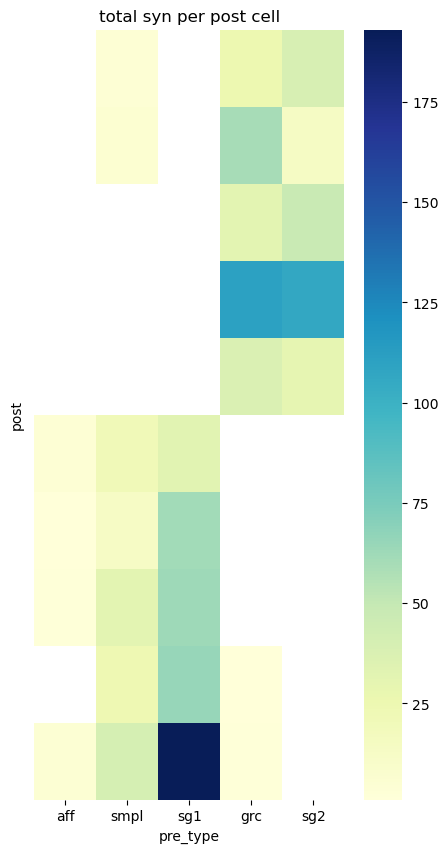

In [54]:
target_order = ['aff','smpl','sg1','grc','sg2']#['lg','mg1','lf','mg2']#['lg','mg1','sg1','lf','mg2','sg2']#
df_map = df_map.loc[:,[t for t in target_order if t in df_map.columns.values]]

cmap = sns.color_palette("YlGnBu", as_cmap=True)  # Base colormap
cmap.set_under('white')  # Set color for values below the colormap's minimum (i.e., 0)

# Ensure all 0s are treated as "under" the colormap range
# df_map = df_map.replace(0, -1)  # Replace 0s with a value below the colormap range


# fig, axes = plt.subplots(1, figsize=(5,10))
# sns.heatmap(data=df_map.sort_values(['lg']), annot=False, fmt="0.0f", cmap="YlGnBu", ax=axes)#  .sort_index()
# # sns.heatmap(data=df_map.div(df_map.sum(axis=1),axis=0).mul(100).round(0), annot=True, fmt="0.0f", cmap="YlGnBu", ax=axes[1])
# axes.set_title('total syn per pre cell')




# Plot the heatmap
fig, axes = plt.subplots(1, figsize=(5,10))
sns.heatmap(data=df_map.sort_values(['sg1']), annot=False, fmt="0.0f", cmap=cmap, 
            ax=axes, vmin=1)  # vmin slightly above 0 to treat negative as "under"
axes.set_title('total syn per post cell')
axes.set_yticks([])



In [55]:
sg1_map = df_map[df_map['sg1']>1].sort_values(['sg1'])

In [56]:
sg2_map = df_map[~df_map.index.isin(sg1_map.index)].sort_values(['sg2'],ascending=False)

In [57]:
sorted_full = pd.concat([sg2_map,sg1_map])

[]

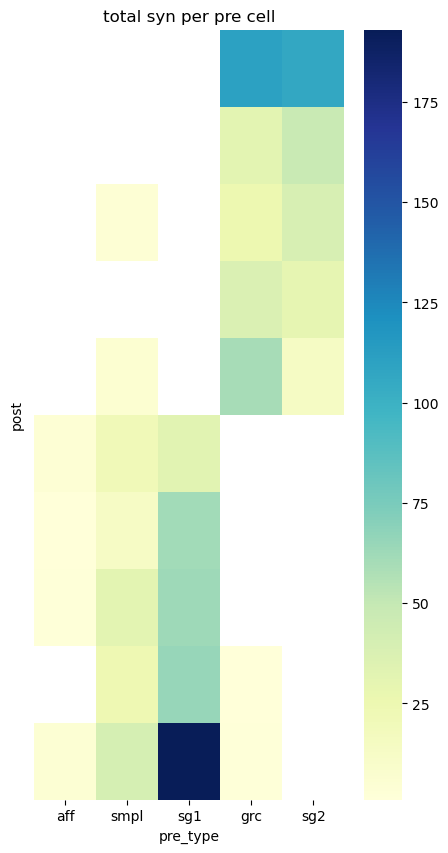

In [58]:
# Plot the heatmap
fig, axes = plt.subplots(1, figsize=(5,10))
sns.heatmap(data=sorted_full, annot=False, fmt="0.0f", cmap=cmap, 
            ax=axes, vmin=1)  # vmin slightly above 0 to treat negative as "under"
axes.set_title('total syn per pre cell')
axes.set_yticks([])

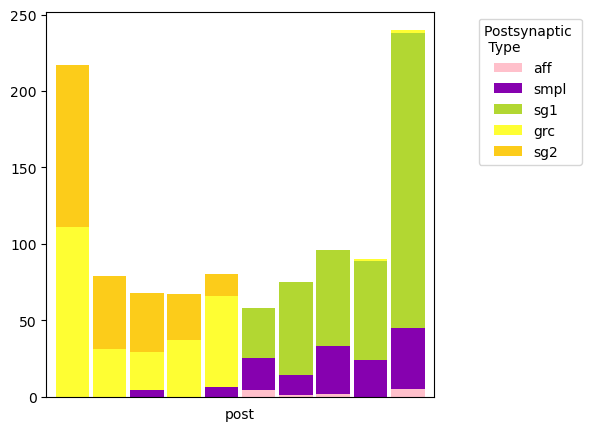

In [59]:
# Plotting
fig, ax = plt.subplots(figsize=(5, 5))
# Create a stacked bar plot
sorted_full.loc[:,target_order].plot.bar(stacked=True,color = syn_colors,ax=ax, width=0.9)
ax.set_xticks([])
ax.legend(title='Postsynaptic \n Type', bbox_to_anchor=(1.4, 1), loc='upper right')
plt.savefig('/Users/kperks/Downloads/MG_stacked_bar_presyn.svg', format='svg', transparent=True)

In [221]:
df_norm = df_map.div(df_map.sum(axis=1),axis=0).mul(100)#.round(0)

In [222]:
sg1_map = df_norm[df_norm['sg1']>1].sort_values(['sg1'])

sg2_map = df_norm[~df_norm.index.isin(sg1_map.index)].sort_values(['sg2'],ascending=False)

norm_sorted_full = pd.concat([sg2_map,sg1_map])

[]

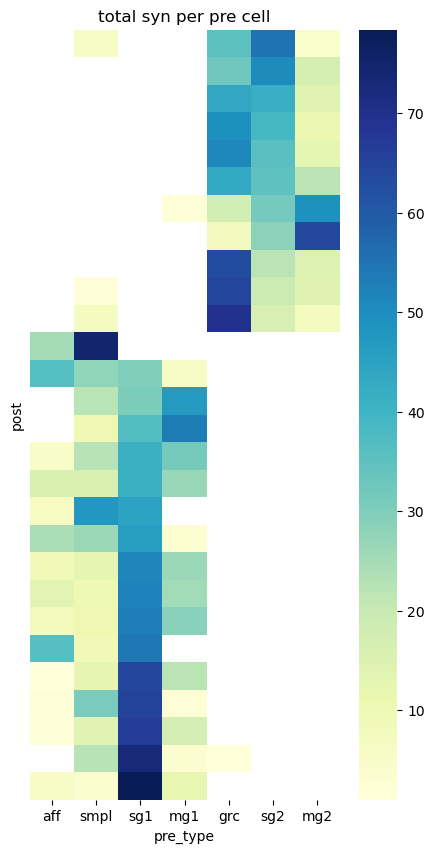

In [223]:
# Plot the heatmap
fig, axes = plt.subplots(1, figsize=(5,10))
sns.heatmap(data=norm_sorted_full, annot=False, fmt="0.0f", cmap=cmap, 
            ax=axes, vmin=1)  # vmin slightly above 0 to treat negative as "under"
axes.set_title('total syn per pre cell')
axes.set_yticks([])

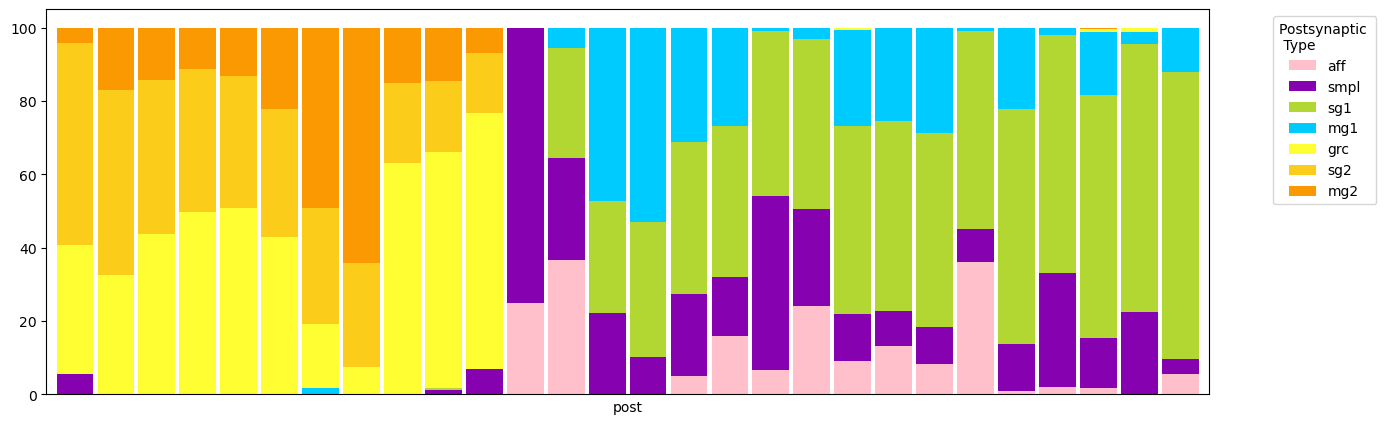

In [224]:
# Plotting
fig, ax = plt.subplots(figsize=(15, 5))
# Create a stacked bar plot
norm_sorted_full.loc[:,target_order].plot.bar(stacked=True,color = syn_colors,ax=ax, width=0.9)
ax.set_xticks([])
ax.legend(title='Postsynaptic \n Type', bbox_to_anchor=(1.15, 1), loc='upper right')
plt.savefig('/Users/kperks/Downloads/mg_output_stacked_bar_presyn_normalized.svg', format='svg', transparent=True)

# KC fig 4 analysis

In [434]:
def get_p_connect(df_edges,count_type):

# count_type = 'nsyn' # 'ncells' #
# mask = (df_edges['post_type'].isin(['sg1','sg2','mg1','mg2','lg','lf']))#,'mli','tsd','dml'])) # df_edges['pre'].isin([290552453,27220895,31694533,102463116,188296613,15401313,17877032,187151336,117041378,122039969,36165549]) & 
#[295969348,295969442,295969134,295969355,295968777,282228761,283375247, 283391297,283390956,282230475,268614458,268614383,273086215,187230424]

    # types_ = ['mg1','mg2','lg','lf']# 
    # df_map = pd.DataFrame()
    # for t in types_:
    #     if count_type == 'nsyn':
    #         df_grouped = df_edges[(df_edges['post_type']==t)].groupby(
    #             ['post','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(
    #             index='post', columns='pre_type', values='weight').fillna(0).reset_index()
        
    #     # if count_type == 'ncells':
    #     #     df_grouped = df_edges[(df_edges['pre_type']==t)].groupby(
    #     #         ['pre','pre_type','post_type']).count().reset_index().pivot(
    #     #         index='pre', columns='post_type', values='post').fillna(0).reset_index()
        
    #     df_grouped['post_type']=t
    #     df_map = pd.concat([df_map,df_grouped])
        
    # df_map = df_map.fillna(0)
    # df_map = df_map.set_index('post')
    # df_map = df_map.drop(['post_type'],axis=1)

    df_map = df_edges.groupby(['post','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(index='post', columns='pre_type', values='weight').fillna(0).reset_index().set_index('post')
    
    df_norm = df_map.div(df_map.sum(axis=1),axis=0)#.mul(100).round(0)

    return df_norm
# sns.heatmap(data=df_norm.sort_values('lcf'), annot=True, fmt="0.0f", cmap="YlGnBu")

## data

In [74]:
df_syn['post_type'].unique()

array(['mg2', 'sg1', 'sgx1', 'sg2', 'smpl', 'grc', 'mli', 'mg1', 'lg',
       'lf', 'sgx2', 'h'], dtype=object)

In [75]:
df_syn.head()

,Unnamed: 0,post,pre,structure,x,y,z,y_adj,pre_type,post_type
0,0,126649726,305329558,axon,333.376,306.304,50.70,-49.606710,sg1,mg2
1,1,126649726,221714230,axon,341.472,295.248,37.11,-40.070481,smpl,mg2
2,2,126649726,302730452,axon,229.456,307.280,52.86,-51.985349,sg1,mg2
3,3,126649726,44244249,axon,337.200,270.496,19.05,-17.969978,smpl,mg2
4,4,126649726,559551706,axon,322.752,307.680,65.13,-49.580579,mg1,mg2


## connection probability by cell type

In [465]:
count_type = 'nsyn'
included_groups = ['aff','smpl','sg1','grc','sg2']
by_group='sg2'

### data

In [466]:
df_syn_data = deepcopy(df_syn)
mask = df_syn_data['pre_type'].isin(included_groups) & df_syn_data['post_type'].isin(['mg1','mg2','lg','lf'])  # Filter out rows with post_type not in post_types_order and pre_tyep not in pre_types_order
df_syn_data = df_syn_data[mask]
# df_syn_data.to_csv('/Users/kperks/Downloads/df_syn_data.csv')
df_edges_data=df_syn_data.drop(['Unnamed: 0','x','y','z','structure'],axis=1).value_counts().reset_index(name='weight')

df_norm_data = get_p_connect(df_edges_data,count_type)


result_data = df_norm_data[(df_norm_data[by_group] != 0)].mean()

### shuffle result

In [467]:
result_shuff = pd.DataFrame()

# Iterate the specified number of times
for i in range(10):
    df_syn_shuff = deepcopy(df_syn)
    mask = df_syn_shuff['pre_type'].isin(included_groups) & df_syn_shuff['post_type'].isin(['mg1','mg2','lg','lf'])  # Filter out rows with post_type not in post_types_order and pre_tyep not in pre_types_order
    df_syn_shuff = df_syn_shuff[mask]
    # Shuffle the dataframe
    # df_syn_rand.loc[:,['pre']] = df_syn_rand['pre'].sample(frac = 1).values ## *** this does not work unless you re-type the pre_type column after***
    shuff_rows = df_syn_shuff[['pre','x','y','z','y_adj','pre_type']].sample(frac = 1)
    df_syn_shuff.loc[:,['pre']] = shuff_rows['pre'].values
    df_syn_shuff.loc[:,['x']] = shuff_rows['x'].values
    df_syn_shuff.loc[:,['y']] = shuff_rows['y'].values
    df_syn_shuff.loc[:,['z']] = shuff_rows['z'].values
    df_syn_shuff.loc[:,['y_adj']] = shuff_rows['y_adj'].values
    df_syn_shuff.loc[:,['pre_type']] = shuff_rows['pre_type'].values

    df_edges_shuff=df_syn_shuff.drop(['Unnamed: 0','x','y','z','y_adj','structure'],axis=1).value_counts().reset_index(name='weight')

    df_norm_shuff = get_p_connect(df_edges_shuff,count_type)
    
    # Compute the mean for rows where 'mg2' is not zero
    mean_row = df_norm_shuff[(df_norm_shuff[by_group] != 0)].mean(numeric_only=True) #df_shuffled[df_shuffled[by_group] != 0].mean(numeric_only=True)
    
    # Append the result as a row to the result_df
    result_shuff = pd.concat([result_shuff, pd.DataFrame([mean_row])], ignore_index=True)

### plot comparison

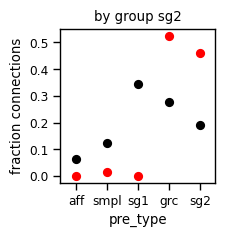

In [468]:
hfig,ax = plt.subplots(1,figsize=(2,2))

# plot single iteration, individual cells
# sns.pointplot(data = df_norm,linestyle='',color = 'black',markersize = 5,order = ['lg','mg1','sg1','lf','mg2','sg2'],errorbar='sd')
# sns.pointplot(data=df_norm_data[(df_norm_data[by_group] != 0)],linestyle='',color = 'red',markersize = 5,order = ['lg','mg1','sg1','lf','mg2','sg2'],errorbar='sd')

# plot iteration means
sns.pointplot(data = result_shuff,linestyle='',color = 'black',markersize = 5,order = included_groups,errorbar=('ci'))
sns.pointplot(data=result_data,linestyle='',color = 'red',markersize = 5,order = included_groups)

ax.set_ylabel('fraction connections')
ax.set_title(f'by group {by_group}')

plt.savefig(f'/Users/kperks/Downloads/input_conditionalP_{by_group}.svg', format='svg', transparent=True)

# conditional input analysis

In [444]:
def get_conditional_input(df_edges,normalize=False):
    '''get p(connect)'''
    df_map = df_edges.groupby(['post','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(index='post', columns='pre_type', values='weight').fillna(0).reset_index().set_index('post')

    if normalize==True:
        df_map = df_map.div(df_map.sum(axis=1),axis=0)
    
    '''group data'''
    result = []
    for g in df_map.columns:
        result.append(list(df_map[(df_map[g] > 0.05)].mean().values))
    
    return result

In [425]:
included_groups = ['aff','smpl','sg1','grc','sg2']

### shuffle result

In [445]:
result_shuff = []

# Iterate the specified number of times
for i in range(100):
    df_syn_shuff = deepcopy(df_syn)
    mask = df_syn_shuff['pre_type'].isin(included_groups) & df_syn_shuff['post_type'].isin(['mg1','mg2','lg','lf'])  # Filter out rows with post_type not in post_types_order and pre_tyep not in pre_types_order
    df_syn_shuff = df_syn_shuff[mask]
    # Shuffle the dataframe
    # df_syn_rand.loc[:,['pre']] = df_syn_rand['pre'].sample(frac = 1).values ## *** this does not work unless you re-type the pre_type column after***
    shuff_rows = df_syn_shuff[['pre','x','y','z','y_adj','pre_type']].sample(frac = 1)
    df_syn_shuff.loc[:,['pre']] = shuff_rows['pre'].values
    df_syn_shuff.loc[:,['x']] = shuff_rows['x'].values
    df_syn_shuff.loc[:,['y']] = shuff_rows['y'].values
    df_syn_shuff.loc[:,['z']] = shuff_rows['z'].values
    df_syn_shuff.loc[:,['y_adj']] = shuff_rows['y_adj'].values
    df_syn_shuff.loc[:,['pre_type']] = shuff_rows['pre_type'].values

    df_edges_shuff=df_syn_shuff.drop(['Unnamed: 0','x','y','z','y_adj','structure'],axis=1).value_counts().reset_index(name='weight')

    result_ = np.asarray(get_conditional_input(df_edges_shuff,normalize=True))
    
    # Append the result as a row to the result_df
    result_shuff.append(result_)

result_shuff = np.asarray(result_shuff)

u_mat = result_shuff.mean(axis=0)

std_mat = result_shuff.std(axis=0)

In [447]:
std_mat

array([[0.004002  , 0.00787315, 0.00819451, 0.0072432 , 0.00554232],
       [0.00307996, 0.00610087, 0.00576006, 0.00536658, 0.00393281],
       [0.00307996, 0.00610087, 0.00576006, 0.00536658, 0.00393281],
       [0.00300618, 0.00601076, 0.00556806, 0.00505862, 0.00377186],
       [0.00288561, 0.00596728, 0.00577942, 0.00492433, 0.00408652]])

### data

In [450]:
df_syn_data = deepcopy(df_syn)
mask = df_syn_data['pre_type'].isin(included_groups) & df_syn_data['post_type'].isin(['mg1','mg2','lg','lf'])  # Filter out rows with post_type not in post_types_order and pre_tyep not in pre_types_order
df_syn_data = df_syn_data[mask]

df_edges_data=df_syn_data.drop(['Unnamed: 0','x','y','z','structure'],axis=1).value_counts().reset_index(name='weight')

result_data = get_conditional_input(df_edges_data,normalize=True)

# Calculate the z-scores
z_scores = (result_data - u_mat) / std_mat
z_scores[np.isclose(std_mat, 0)] = 0  # Replace z-scores with 0 where std is 0 # Handle cases where std_2d is zero to avoid division by zero


cond_input_mat = pd.DataFrame(z_scores,columns = df_map.columns, index = df_map.columns)


In [451]:
cond_input_mat

pre_type,aff,grc,sg1,sg2,smpl
pre_type,,,,,
aff,27.228750,-35.233590,23.773180,-25.212609,28.190410
grc,-20.526669,39.760386,-60.473321,51.471580,-27.270076
sg1,17.795998,-45.900204,51.153806,-34.519880,29.450945
sg2,-20.993949,40.393723,-62.518821,54.456665,-28.381923
smpl,16.224483,-36.966642,33.462364,-29.427935,30.659936


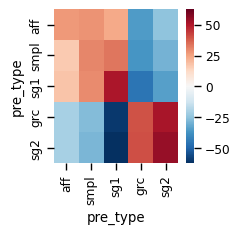

In [452]:

# Define the desired order
order = ['aff', 'smpl', 'sg1', 'grc', 'sg2']

# Reorder rows and columns
df_reordered=cond_input_mat.reindex(index=order, columns=order)

# Ensure the color range is centered around 0
vmin = -max(abs(df_reordered.min().min()), abs(df_reordered.max().max()))
vmax = -vmin

sns.set_context("paper",font_scale=1)
hfig,ax = plt.subplots(1,figsize=(2,2))
sns.heatmap(df_reordered,
    cmap="RdBu_r",  # Diverging colormap from red to blue
    vmin=vmin,
    vmax=vmax,
    center=0)

plt.savefig('/Users/kperks/Downloads/mg_output_conditional_input_analysis.svg', format='svg', transparent=True)

### an example of shuffle result

<AxesSubplot:xlabel='pre_type', ylabel='pre_type'>

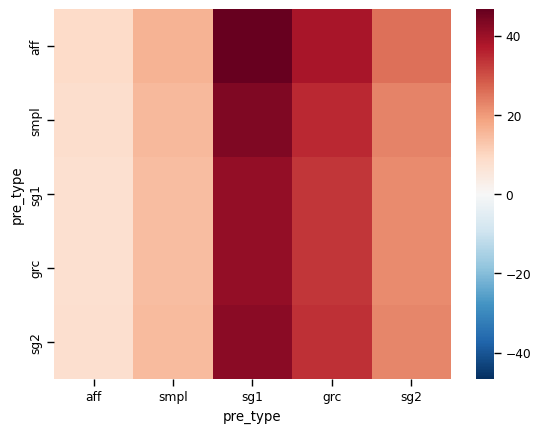

In [408]:

df_syn_shuff = deepcopy(df_syn)
mask = df_syn_shuff['pre_type'].isin(included_groups) & df_syn_shuff['post_type'].isin(['mg1','mg2','lg','lf'])  # Filter out rows with post_type not in post_types_order and pre_tyep not in pre_types_order
df_syn_shuff = df_syn_shuff[mask]
# Shuffle the dataframe
# df_syn_rand.loc[:,['pre']] = df_syn_rand['pre'].sample(frac = 1).values ## *** this does not work unless you re-type the pre_type column after***
shuff_rows = df_syn_shuff[['pre','x','y','z','y_adj','pre_type']].sample(frac = 1)
df_syn_shuff.loc[:,['pre']] = shuff_rows['pre'].values
df_syn_shuff.loc[:,['x']] = shuff_rows['x'].values
df_syn_shuff.loc[:,['y']] = shuff_rows['y'].values
df_syn_shuff.loc[:,['z']] = shuff_rows['z'].values
df_syn_shuff.loc[:,['y_adj']] = shuff_rows['y_adj'].values
df_syn_shuff.loc[:,['pre_type']] = shuff_rows['pre_type'].values

df_edges_shuff=df_syn_shuff.drop(['Unnamed: 0','x','y','z','y_adj','structure'],axis=1).value_counts().reset_index(name='weight')

result_ = np.asarray(get_conditional_input(df_edges_shuff))

cond_input_mat = pd.DataFrame(result_,columns = df_map.columns, index = df_map.columns)

# Define the desired order
order = ['aff', 'smpl', 'sg1', 'grc', 'sg2']

# Reorder rows and columns
df_reordered=cond_input_mat.reindex(index=order, columns=order)

# Ensure the color range is centered around 0
vmin = -max(abs(df_reordered.min().min()), abs(df_reordered.max().max()))
vmax = -vmin

sns.heatmap(df_reordered,
    cmap="RdBu_r",  # Diverging colormap from red to blue
    vmin=vmin,
    vmax=vmax,
    center=0)

# Patterns of connectivity (PCA)

In [62]:
def calculate_percent_total(row):
    total = row.sum()
    if total == 0:
        return row  # If total is 0, return the row as is (unchanged)
    else:
        return row / total  # Normalize by dividing each element by the total
#row / total 

## params of analysis

In [469]:
# post-synaptic labeling
dsource = 'post_type'
idsource = 'post'
dtarget = 'pre_type'

# Desired pre_types and order
source_types_order = ['lg','mg1','lf','mg2']#['pf']#
# Desired post_types order
target_types_order =  ['aff', 'smpl', 'sg1', 'grc', 'sg2']#['mg1','lg', 'mg2','lf'] #

## data

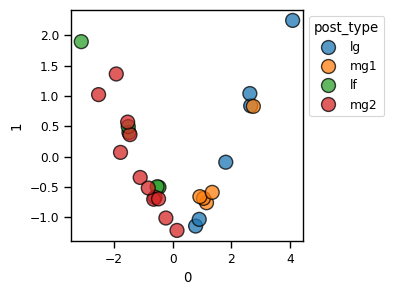

In [482]:
df_syn_data = deepcopy(df_syn)
mask = df_syn_data[dsource].isin(source_types_order) & df_syn_data[dtarget].isin(target_types_order)  # Filter out rows with post_type not in post_types_order and pre_tyep not in pre_types_order
df_syn_data = df_syn_data[mask]
# df_syn_data.to_csv('/Users/kperks/Downloads/df_syn_data.csv')
df_edges_data=df_syn_data.drop(['Unnamed: 0','x','y','z','structure'],axis=1).value_counts().reset_index(name='weight')

# Pivot table to get sum of weights per post cell and pre_type
pivot_df = df_edges_data.pivot_table(values='weight', index=[idsource, dsource], columns=dtarget, aggfunc='sum', fill_value=0)

# Reindex columns to include only the specified pre_types in the desired order
pivot_df = pivot_df.reindex(columns=target_types_order, fill_value=0)

# Reset index to turn 'post' and 'post_type' from index to columns
pivot_df.reset_index(inplace=True)

# Sort the dataframe based on post_type
pivot_df[dsource] = pd.Categorical(pivot_df[dsource], categories=source_types_order, ordered=True)
pivot_df.sort_values(dsource, inplace=True)
pivot_df.set_index(idsource, inplace=True)

# Apply the function to each row
# norm_df = pivot_df.drop(columns=dsource).apply(calculate_percent_total, axis=1)
norm_df = pivot_df.select_dtypes(include='number')# Standard scaling (next step) should take care of normalizing row-wise, so should not need to do percent total each row, correct? .apply(calculate_percent_total, axis=1) #axis=1 applies function to each row.

# Standardize the data
scaler = StandardScaler(with_mean=True, with_std=True) # should this be scaled based on null model mean and std instead of within df mean and std?
scaled_data = scaler.fit_transform(norm_df)

# Perform PCA
npc = len(target_types_order)
pca = PCA(n_components=npc)  # You can change the number of components as needed

pca_result = pca.fit_transform(scaled_data)

# get loadings of dimensions onto each principal component
loadings = pca.components_.T

# Add PCA results to the DataFrame
for i in range(npc):
    pivot_df[str(i)] = pca_result[:, i]

result_data = pd.DataFrame(pca.explained_variance_ratio_.reshape(1, -1),columns=range(len(pca.explained_variance_ratio_)))

hfig,ax = plt.subplots(1,figsize=(3,3))
sns.scatterplot(ax=ax,data=pivot_df,hue=dsource,x='0',y='1',linewidth=1,edgecolor='black',s=100,alpha = 0.75)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.savefig('/Users/kperks/Downloads/mg_output_PCA.svg', format='svg', transparent=True)



### shuffle result

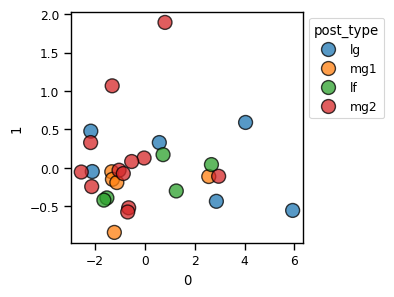

In [483]:
result_df = pd.DataFrame()

# Iterate the specified number of times
for i in range(10):

    df_syn_shuff = deepcopy(df_syn)

    mask = df_syn_shuff[dsource].isin(source_types_order) & df_syn_shuff[dtarget].isin(target_types_order)  # Filter out rows with post_type not in post_types_order and pre_tyep not in pre_types_order
    df_syn_shuff = df_syn_shuff[mask]

    # Shuffle the dataframe
    # df_syn_rand.loc[:,['pre']] = df_syn_rand['pre'].sample(frac = 1).values ## *** this does not work unless you re-type the pre_type column after***
    shuff_rows = df_syn_shuff[['pre','x','y','z','y_adj','pre_type']].sample(frac = 1)
    df_syn_shuff.loc[:,['pre']] = shuff_rows['pre'].values
    df_syn_shuff.loc[:,['x']] = shuff_rows['x'].values
    df_syn_shuff.loc[:,['y']] = shuff_rows['y'].values
    df_syn_shuff.loc[:,['z']] = shuff_rows['z'].values
    df_syn_shuff.loc[:,['y_adj']] = shuff_rows['y_adj'].values
    df_syn_shuff.loc[:,['pre_type']] = shuff_rows['pre_type'].values
        
    df_edges_shuff=df_syn_shuff.drop(['Unnamed: 0','x','y','z','structure'],axis=1).value_counts().reset_index(name='weight')
    
    # Pivot table to get sum of weights per post and pre_type
    pivot_df = df_edges_shuff.pivot_table(values='weight', index=[idsource, dsource], columns=dtarget, aggfunc='sum', fill_value=0)
    
    # Reindex columns to include only the specified pre_types in the desired order
    pivot_df = pivot_df.reindex(columns=target_types_order, fill_value=0)
    
    # Reset index to turn 'post' and 'post_type' from index to columns
    pivot_df.reset_index(inplace=True)
    
    # Sort the dataframe based on post_type
    pivot_df[dsource] = pd.Categorical(pivot_df[dsource], categories=source_types_order, ordered=True)
    pivot_df.sort_values(dsource, inplace=True)
    pivot_df.set_index(idsource, inplace=True)
    
    # Apply the function to each row
    # norm_df = pivot_df.drop(columns=dsource).apply(calculate_percent_total, axis=1)
    norm_df = pivot_df.select_dtypes(include='number')#.apply(calculate_percent_total, axis=1)
    
    # Standardize the data
    scaler = StandardScaler(with_mean=True, with_std=True)
    scaled_data = scaler.fit_transform(norm_df)
    
    # Perform PCA
    npc = len(target_types_order)
    pca = PCA(n_components=npc)  # You can change the number of components as needed
    pca_result = pca.fit_transform(scaled_data)

        # get loadings of dimensions onto each principal component
    loadings = pca.components_.T
    
    # Add PCA results to the DataFrame
    for i in range(npc):
        pivot_df[str(i)] = pca_result[:, i]
    
    # Append the result as a row to the result_df
    result_df = pd.concat([result_df, pd.DataFrame(pca.explained_variance_ratio_.reshape(1, -1))], ignore_index=True)

hfig,ax = plt.subplots(1,figsize=(3,3))
sns.scatterplot(ax=ax,data=pivot_df,hue=dsource,x='0',y='1',linewidth=1,edgecolor='black',s=100,alpha = 0.75)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.savefig('/Users/kperks/Downloads/mg_output_PCA_shuffled.svg', format='svg', transparent=True)

### plot comparison

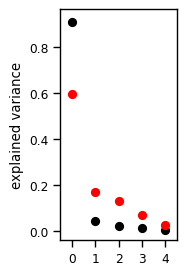

In [478]:
hfig,ax = plt.subplots(1,figsize=(1.5,3))

# plot single iteration, individual cells
# sns.pointplot(data = df_norm,linestyle='',color = 'black',markersize = 5,order = ['lg','mg1','sg1','lf','mg2','sg2'])
# sns.pointplot(data=df_norm_data[(df_norm_data[by_group] != 0)],linestyle='',color = 'red',markersize = 5,order = ['lg','mg1','sg1','lf','mg2','sg2'])

# plot iteration means
sns.pointplot(data = result_df,linestyle='',color = 'black',markersize = 5,errorbar='ci')
sns.pointplot(data=result_data,linestyle='',color = 'red',markersize = 5)

ax.set_ylabel('explained variance')
plt.savefig('/Users/kperks/Downloads/input_pca.svg', format='svg', transparent=True)

In [166]:

# an example iteration of shuffling:
shuff_rows = df_syn_shuff[['pre','x','y','z','y_adj','pre_type']].sample(frac = 1)
df_syn_shuff.loc[:,['pre']] = shuff_rows['pre'].values
df_syn_shuff.loc[:,['x']] = shuff_rows['x'].values
df_syn_shuff.loc[:,['y']] = shuff_rows['y'].values
df_syn_shuff.loc[:,['z']] = shuff_rows['z'].values
df_syn_shuff.loc[:,['y_adj']] = shuff_rows['y_adj'].values
df_syn_shuff.loc[:,['pre_type']] = shuff_rows['pre_type'].values

df_syn_shuff.to_csv('/Users/kperks/Downloads/df_syn_shuff.csv')

# SG input population split for model

In [58]:
metadata_path = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/CREST_reconstructions/mg-network/metadata/sg_pre_crude_split.csv')

In [64]:
# open csv into pandas

metadata_df = pd.read_csv(metadata_path)

In [43]:
mask = df_edges['post'].isin([299496636,214581797,393325331,301787806])
df_edges[mask].groupby(['post_type','pre_type'])['pre'].count() #['weight'].sum()

post_type  pre_type
lf         aff           9
           fov         113
           grc           1
           h             8
           mg1          19
           sg1          53
           sgx1         18
           smpl         20
           uk            9
lg         fov          36
           grc         123
           lg            1
           mg2          12
           mli           3
           pe            2
           pf            2
           sg2          30
           sgx2          8
           smpl          1
           uk           10
mg1        fov          66
           grc          87
           mg2          17
           mli          22
           pe           36
           pf           27
           sg2          57
           sgx2         10
           uk            5
mg2        aff           3
           fov          87
           grc           1
           mg1          10
           mg2           1
           mli          18
           pe           33
        

In [89]:
mask = df_edges['post'].isin([299496636,214581797,393325331,301787806]) & df_edges['pre_type'].isin(['sg1','sg2','mg1','mg2'])
result_df = df_edges[mask]

In [94]:
result_df

,post,pre,pre_type,post_type,weight
6,301787806,214827705,sg2,lg,18
7,301787806,128879866,sg2,lg,16
11,214581797,300459385,mg1,mg2,15
15,393325331,644143297,mg1,lf,14
20,393325331,642905044,mg1,lf,12
...,...,...,...,...,...
5261,299496636,474839189,mg2,mg1,1
5274,299496636,472437904,sg2,mg1,1
5290,301787806,220352133,sg2,lg,1
5334,301787806,137991336,sg2,lg,1


In [100]:
df_type[df_type['id'].isin([214827705])]

,Unnamed: 0,id,cell_type
792,792,214827705,sg2


In [116]:
for i,r in result_df.iterrows():
    # print(i,metadata_df[metadata_df['ID']==r['pre']]['ad_top_half'].values[0])
    # print(r['pre'])
    # print(df_type[df_type['id'].isin([214827705])]['cell_type'].values[0] in ['sg2','sg1'])
    # print(metadata_df[metadata_df['ID']==r['pre']]['ad_top_half'].values[0])
    if df_type[df_type['id'].isin([r['pre']])]['cell_type'].values[0] in ['sg1','sg2']:
        result_df.loc[i,'ad_top_half'] = metadata_df[metadata_df['ID']==r['pre']]['ad_top_half'].values[0]
    if df_type[df_type['id'].isin([r['pre']])]['cell_type'].values[0] in ['mg1','mg2']:
        result_df.loc[i,'ad_top_half'] = 'mg' #df_type[df_type['id']==r['pre']]['cell_type'].values[0]


In [132]:
summary_df = pd.DataFrame(result_df.groupby(['post','ad_top_half'])['pre_type'].count()).reset_index()

In [147]:
summary_df.head()

,post,ad_top_half,pre_type
0,214581797,False,51
1,214581797,True,33
2,214581797,mg,11
3,299496636,False,35
4,299496636,True,20


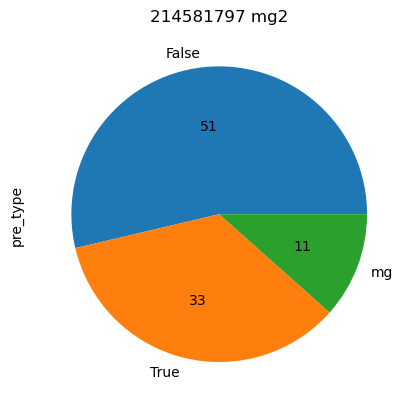

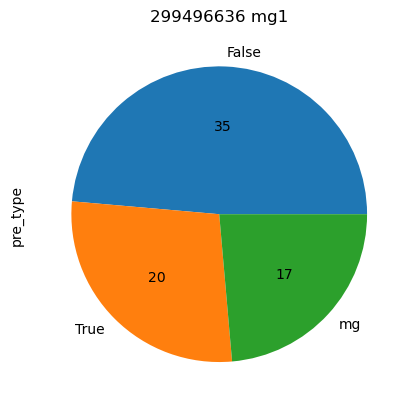

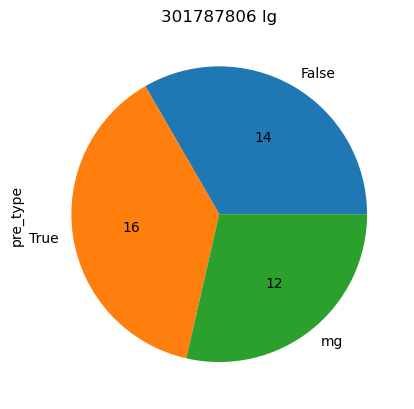

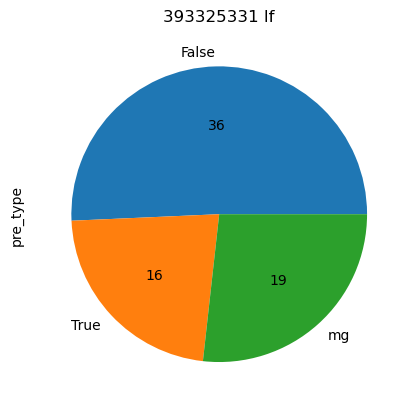

In [146]:
for c_id in summary_df['post'].unique():
    #c_id = 214581797
    ctype = df_type[df_type['id']==c_id]['cell_type'].values[0]
    mask = summary_df['post'].isin([c_id])
    summary_df[mask].plot.pie(y='pre_type', labels=summary_df['ad_top_half'], autopct=lambda p: '{:.0f}'.format(p * sum(summary_df[mask]['pre_type']) / 100),legend=False)# '%1.0f%%')
    plt.title(f'{c_id} {ctype}');

In [148]:
summary_df = pd.DataFrame(result_df.groupby(['post','ad_top_half'])['weight'].sum()).reset_index()

In [149]:
summary_df.head()

,post,ad_top_half,weight
0,214581797,False,102
1,214581797,True,89
2,214581797,mg,51
3,299496636,False,60
4,299496636,True,42


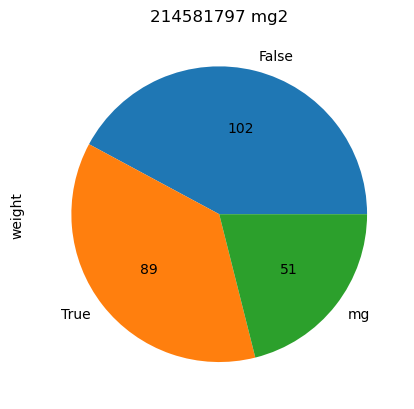

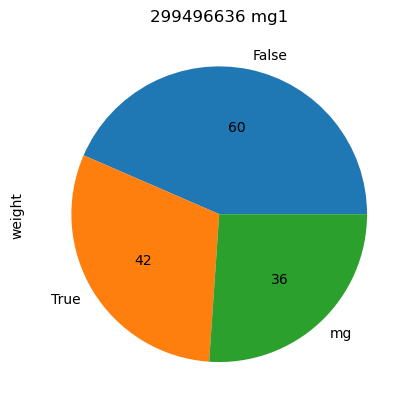

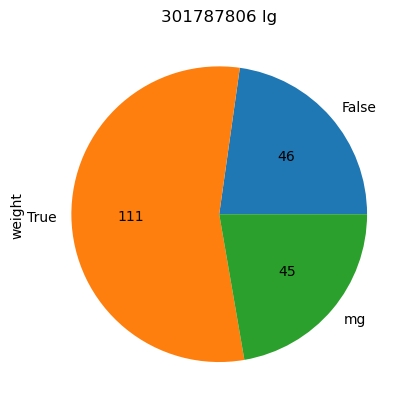

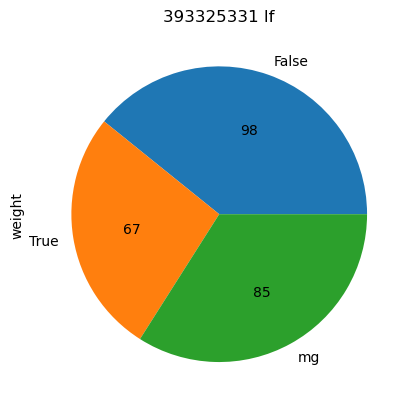

In [151]:
for c_id in summary_df['post'].unique():
    #c_id = 214581797
    ctype = df_type[df_type['id']==c_id]['cell_type'].values[0]
    mask = summary_df['post'].isin([c_id])
    summary_df[mask].plot.pie(y='weight', labels=summary_df['ad_top_half'], autopct=lambda p: '{:.0f}'.format(p * sum(summary_df[mask]['weight']) / 100),legend=False)# '%1.0f%%')
    plt.title(f'{c_id} {ctype}');

# OTHER

## find cells annotated

In [26]:
df_edges.head()

,post,pre,pre_type,post_type,weight
0,394470350,668081112,aff,sgx2,30
1,481412554,668081112,aff,grc,27
2,482680782,60192229,aff,grc,23
3,389891998,668081112,aff,sg2,23
4,483689146,668081112,aff,grc,22


In [28]:
df_edges[df_edges['post_type'].isin(['sg2'])]['post'].unique()

array([389891998,  50786130, 393433572, 306461085, 647514445, 218095913,
       394423863, 477962738, 395507584, 473491444])

## clustermap

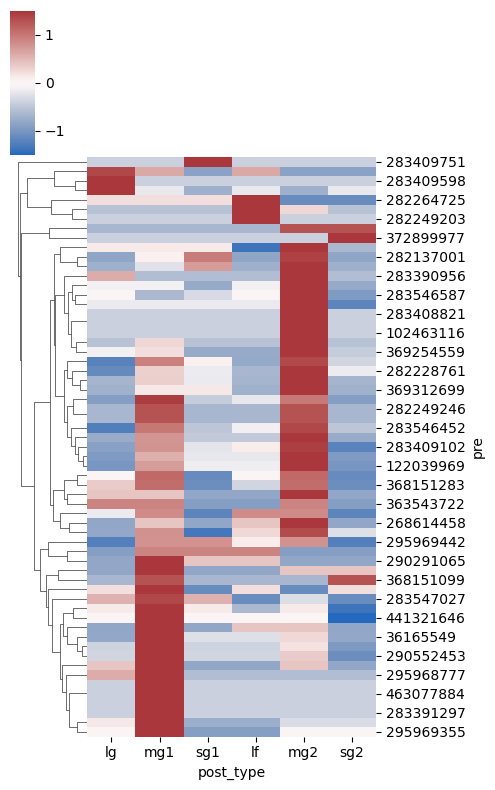

In [180]:

# sns.set(font_scale=1.4)
sns.clustermap(data=df_map,z_score=0,cmap='vlag',col_cluster=False, vmin=-1.5, vmax=1.5,figsize=(5,8))

<Axes: xlabel='lf', ylabel='mg1'>

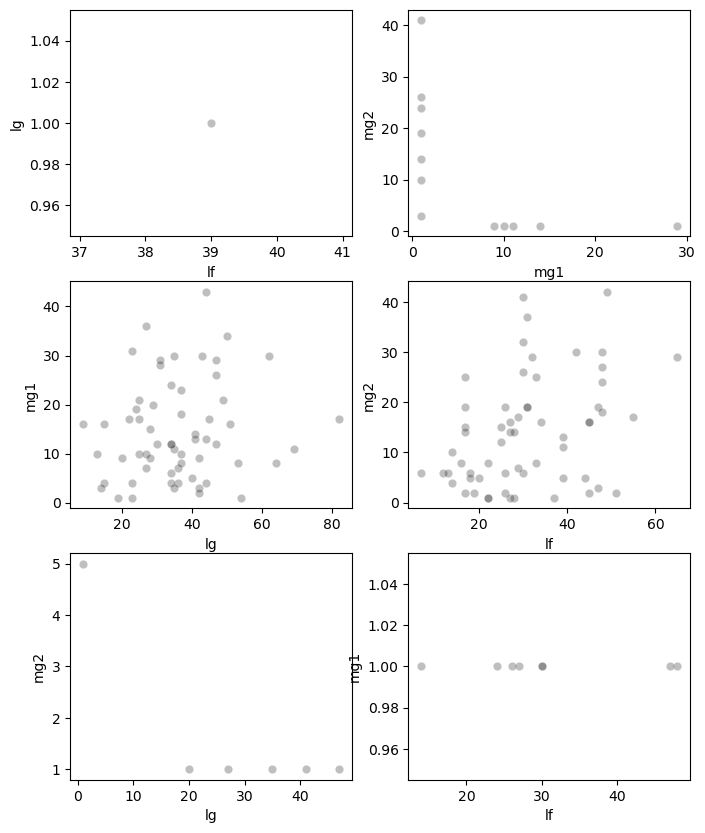

In [163]:
hfig,ax = plt.subplots(3,2,figsize=(8,10))
sns.scatterplot(df_map[(df_map['lg'] != 0)& (df_map['lf'] != 0)], x = 'lf', y = 'lg', ax = ax[0][0],alpha = 0.25,color = 'black')
sns.scatterplot(df_map[(df_map['mg1'] != 0)& (df_map['mg2'] != 0)], x = 'mg1', y = 'mg2', ax = ax[0][1],alpha = 0.25,color = 'black')
sns.scatterplot(df_map[(df_map['lg'] != 0)& (df_map['mg1'] != 0)], x = 'lg', y = 'mg1', ax = ax[1][0],alpha = 0.25,color = 'black')
sns.scatterplot(df_map[(df_map['lf'] != 0)& (df_map['mg2'] != 0)], x = 'lf', y = 'mg2', ax = ax[1][1],alpha = 0.25,color = 'black')
sns.scatterplot(df_map[(df_map['lg'] != 0)& (df_map['mg2'] != 0)], x = 'lg', y = 'mg2', ax = ax[2][0],alpha = 0.25,color = 'black')
sns.scatterplot(df_map[(df_map['lf'] != 0)& (df_map['mg1'] != 0)], x = 'lf', y = 'mg1', ax = ax[2][1],alpha = 0.25,color = 'black')